In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
import tensorflow as tf
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt

In [13]:
IMG_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50


In [14]:
import os
import shutil

# Define source and destination paths
source_path = "/kaggle/input/plant-village/PlantVillage"  # Original dataset path
destination_path = "/kaggle/working/filtered_images"

# List of required class folders
required_classes = ["Potato___Late_blight", "Potato___healthy", "Potato___Early_blight"]

# Create class subdirectories inside the working directory
for class_name in required_classes:
    class_dest_path = os.path.join(destination_path, class_name)
    os.makedirs(class_dest_path, exist_ok=True)  # Create subdirectories if they don't exist
    
    src_class_path = os.path.join(source_path, class_name)  # Original class folder
    
    if os.path.exists(src_class_path):  # Check if the folder exists
        for image_file in os.listdir(src_class_path):
            src_image_path = os.path.join(src_class_path, image_file)
            dst_image_path = os.path.join(class_dest_path, image_file)
            
            if os.path.isfile(src_image_path):  # Ensure it's a file
                shutil.copy2(src_image_path, dst_image_path)  # Copy with metadata
        
        print(f"✅ Copied {class_name} images into structured folders")
    else:
        print(f"❌ {class_name} not found in dataset")

print(f"📂 Dataset is now correctly organized at: {destination_path}")


✅ Copied Potato___Late_blight images into structured folders
✅ Copied Potato___healthy images into structured folders
✅ Copied Potato___Early_blight images into structured folders
📂 Dataset is now correctly organized at: /kaggle/working/filtered_images


In [15]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/working/filtered_images",
    shuffle=True,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [16]:
class_names=dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [17]:
len(dataset)

68

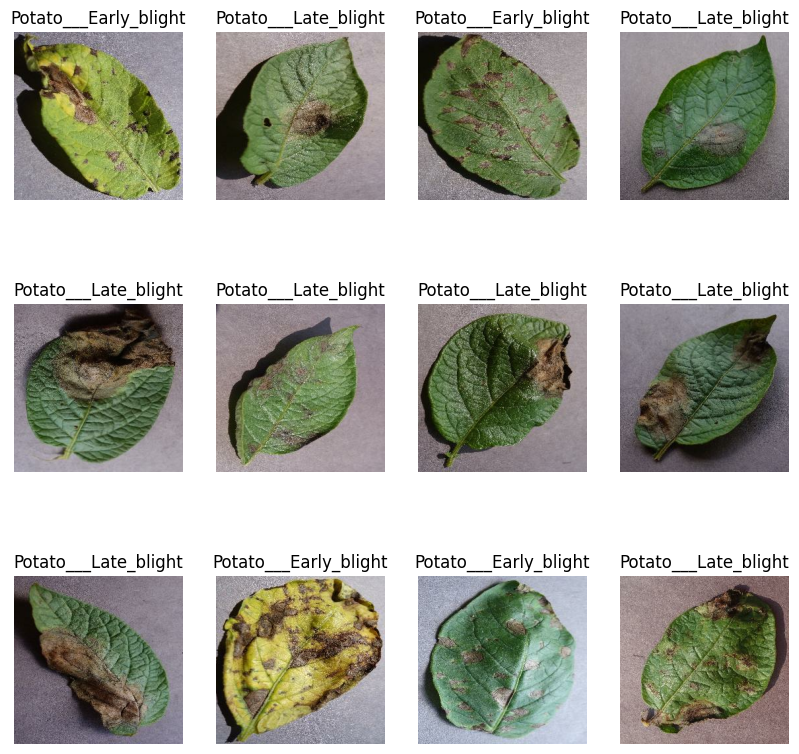

In [60]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):  
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))  
        plt.title(class_names[label_batch[i].numpy()])  # Map index to class name
        plt.axis("off")  
      

In [18]:
len(dataset)



68

In [19]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [20]:
train_ds=dataset.take(54)
len(train_ds)

54

In [21]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [22]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [23]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [24]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [25]:
def get_partition_dataset_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
            ds_size=len(ds)
            if shuffle:
                ds=ds.shuffle(shuffle_size,seed=12)
            train_size=int(train_split*ds_size)
            val_size=int(val_split*ds_size)

            train_ds=ds.take(train_size)
            val_ds=ds.skip(train_size).take(val_size)
            test_ds=ds.skip(train_size).skip(val_size)

            return train_ds,val_ds,test_ds

In [26]:
train_ds,val_ds,test_ds=get_partition_dataset_tf(dataset)

In [27]:
len(train_ds)

54

In [28]:
len(val_ds)

6

In [29]:
len(test_ds)

8

In [30]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
from tensorflow.keras import layers, Sequential

resize_and_rescale = Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1.0 / 255)
])


In [32]:
from tensorflow.keras import layers, Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])



In [33]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:

from tensorflow.keras import layers, models, Sequential

# Define input shape (batch size is handled automatically)
input_shape = (IMG_SIZE, IMG_SIZE, CHANNELS)
n_classes = 3

# Define resizing and rescaling with input shape
resize_and_rescale = Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1.0 / 255)
], name="resize_and_rescale")

# Define the model
model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),  # Ensure input shape is defined
    resize_and_rescale,  # Now it has a defined input shape
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# Print model summary
model.summary()




Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resize_and_rescale (Sequential)      │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [36]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 364ms/step - accuracy: 0.4603 - loss: 0.9540 - val_accuracy: 0.6458 - val_loss: 0.7595
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 285ms/step - accuracy: 0.7315 - loss: 0.6338 - val_accuracy: 0.8333 - val_loss: 0.3957
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 295ms/step - accuracy: 0.8255 - loss: 0.4132 - val_accuracy: 0.8125 - val_loss: 0.4191
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 297ms/step - accuracy: 0.8512 - loss: 0.3680 - val_accuracy: 0.9167 - val_loss: 0.2074
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 293ms/step - accuracy: 0.8853 - loss: 0.2681 - val_accuracy: 0.8854 - val_loss: 0.2906
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 288ms/step - accuracy: 0.9147 - loss: 0.2301 - val_accuracy: 0.7969 - val_loss: 0.4676
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 286ms/step - accuracy: 0.8928 - loss: 0.2823 - val_accuracy: 0.8229 - val_loss: 0.4247
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 288ms/step - accuracy: 0.9099 - loss: 0.2156 - val_accu

In [37]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9846 - loss: 0.0424


In [38]:
scores

[0.0387474000453949, 0.984375]

In [39]:
history

In [40]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [41]:

history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [42]:
type(history.history['loss'])

list

In [43]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8771690726280212,
 0.587099015712738,
 0.41249123215675354,
 0.3500764071941376,
 0.29790234565734863]

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

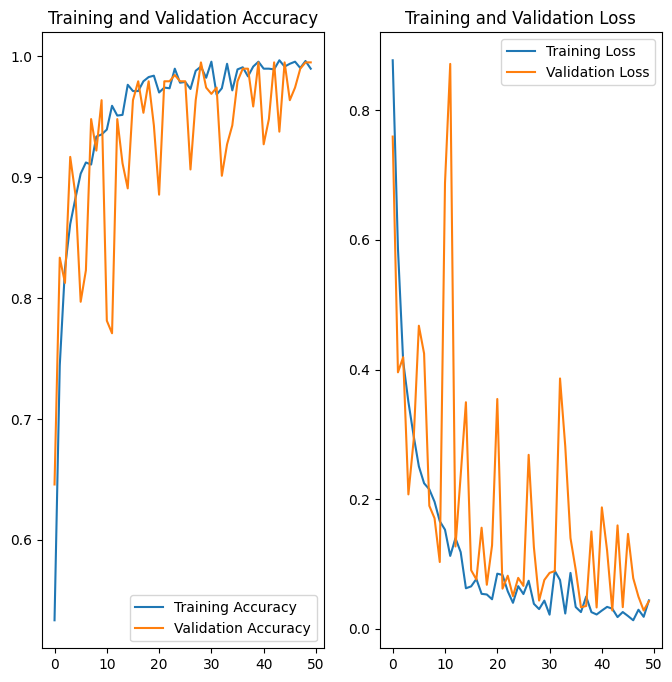

In [45]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
predicted label: Potato___Late_blight


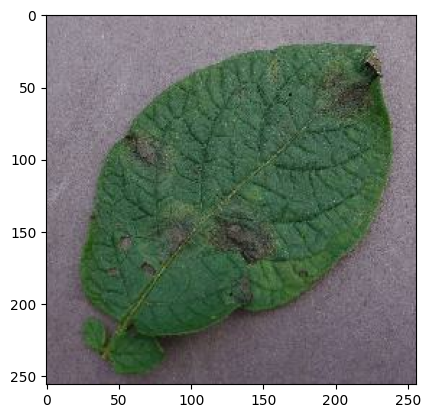

In [47]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [48]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


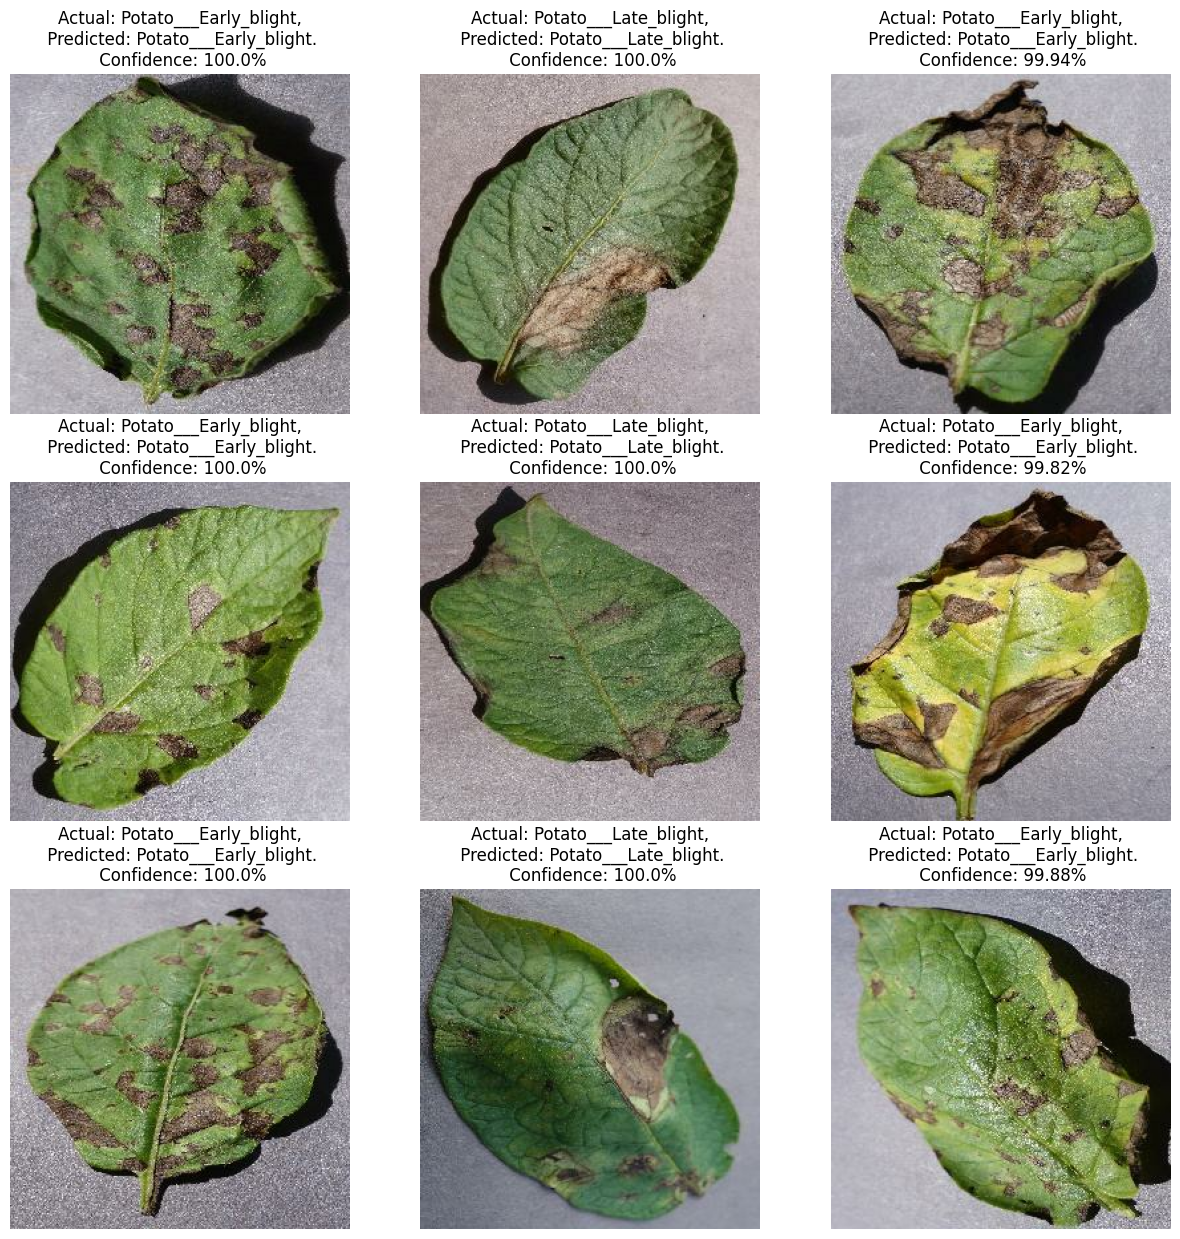

In [49]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [52]:
model.save("/kaggle/working/my_model.keras")



In [53]:
from tensorflow.keras.models import load_model
model = load_model("/kaggle/working/my_model.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
